In [338]:
import wandb

In [339]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [340]:
wandb.init(project="lorenz_rnn", group="Lorenz",save_code=True,notes="Lorenz RNN run and evaluation")

In [341]:
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [342]:
def visualize_3d(obs=None, noiseless_traj=None,times=None, trajs=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if title is not None:
      ax.set_title('Trajectory\n'+title)

    if noiseless_traj is not None:
      z = np.array([o.detach().numpy() for o in noiseless_traj])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color=plt.cm.jet(i/len(z)/1.6))

    if obs is not None:
      z = np.array([o.detach().numpy() for o in obs])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

    if trajs is not None:
      z = np.array([o.detach().numpy() for o in trajs])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='^', color='r', alpha=0.5, linewidths=0, s=45)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    plt.show()

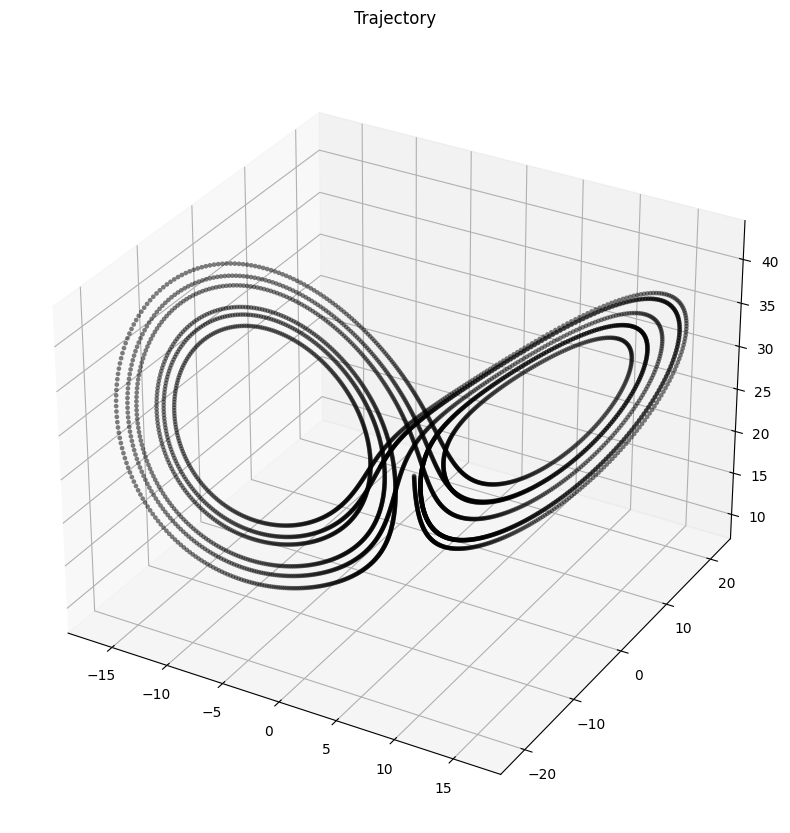

In [343]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[0.5, 0.5, 20.]])  # initial condition
t = torch.linspace(0., 10., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    true_lorenz = odeint(Lorenz(), true_y0, t)

visualize_3d(obs=true_lorenz)

In [344]:
t.shape

torch.Size([5000])

In [345]:
class LorenzRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LorenzRNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size,batch_first=True)
        self.activation = nn.ReLU()
        # Define the linear layer to map from hidden space to output space
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # Reshape the input to match the batch_first format (batch_size, seq_len, input_size)
        

        # Initialize hidden state with zeros
        hidden_state = torch.zeros(1, input_seq.size(0), self.hidden_size)

        # Get RNN outputs and hidden state
        rnn_out, hidden_state = self.rnn(input_seq, hidden_state)
        act_out = self.activation(rnn_out)
        # Apply linear layer to the output of the last time step
        output = self.linear(act_out)

        # Remove the additional batch dimension from the output
        #output = output.squeeze(0)

        return output.squeeze(0)

# Define input size, hidden size, and output size
input_size = 3
hidden_size = 512
output_size = 3

# Create the model
model = LorenzRNN(input_size, hidden_size, output_size)

In [346]:
print(model)

LorenzRNN(
  (rnn): RNN(3, 512, batch_first=True)
  (activation): ReLU()
  (linear): Linear(in_features=512, out_features=3, bias=True)
)


In [347]:
true_lorenz.shape

torch.Size([5000, 1, 3])

In [348]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)  # (batch_size)
    batch_y = torch.stack([true_y[indices + batch_size-1]])  # (batch_size, M, D)
    return batch_y0, batch_y.squeeze(0)

In [349]:
true_lorenz.shape

torch.Size([5000, 1, 3])

In [350]:
b,m = get_batch(true_lorenz, 10)

In [351]:
b.shape, m.shape

(torch.Size([10, 1, 3]), torch.Size([10, 1, 3]))

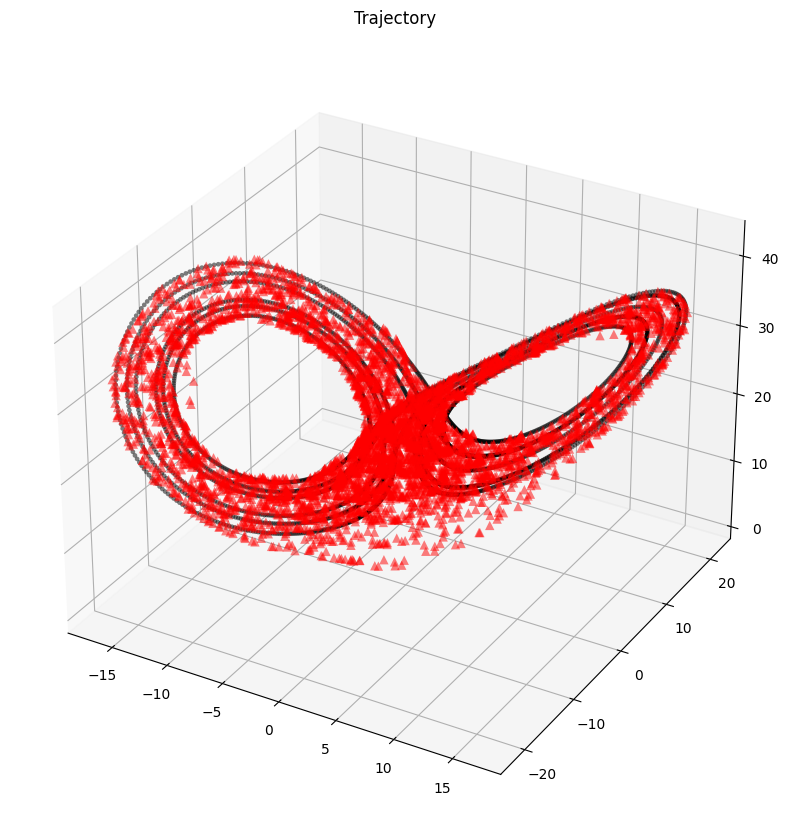

Epoch [9501/10000], Loss: 152.7195


In [352]:

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert true_lorenz to a tensor
true_lorenz_tensor = true_lorenz

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x,y = get_batch(true_lorenz_tensor, batch_size=50)
    # Forward pass
    predicted_lorenz = model(x)

    # Compute the loss
    loss = criterion(predicted_lorenz, y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        
        predictions = []
        with torch.no_grad():
            input_seq = true_lorenz[0]
            for i in range(5000):
                output = model(input_seq.unsqueeze(0))
                predictions.append(output)
                input_seq = output
        predictions = torch.stack(predictions)
        loss = F.mse_loss(predictions, true_lorenz)
        visualize_3d(obs=true_lorenz, trajs=predictions)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        clear_output(wait=True)



In [353]:
output = model(input_seq.unsqueeze(0))

In [354]:
true_y0.shape

torch.Size([1, 3])

In [364]:
predictions = []
with torch.no_grad():
            input_seq = true_lorenz[0]
            for i in range(5000):
                output = model(input_seq.unsqueeze(0))
                predictions.append(output)
                #input_seq = output
               
                input_seq = output
                
            predictions = torch.stack(predictions)

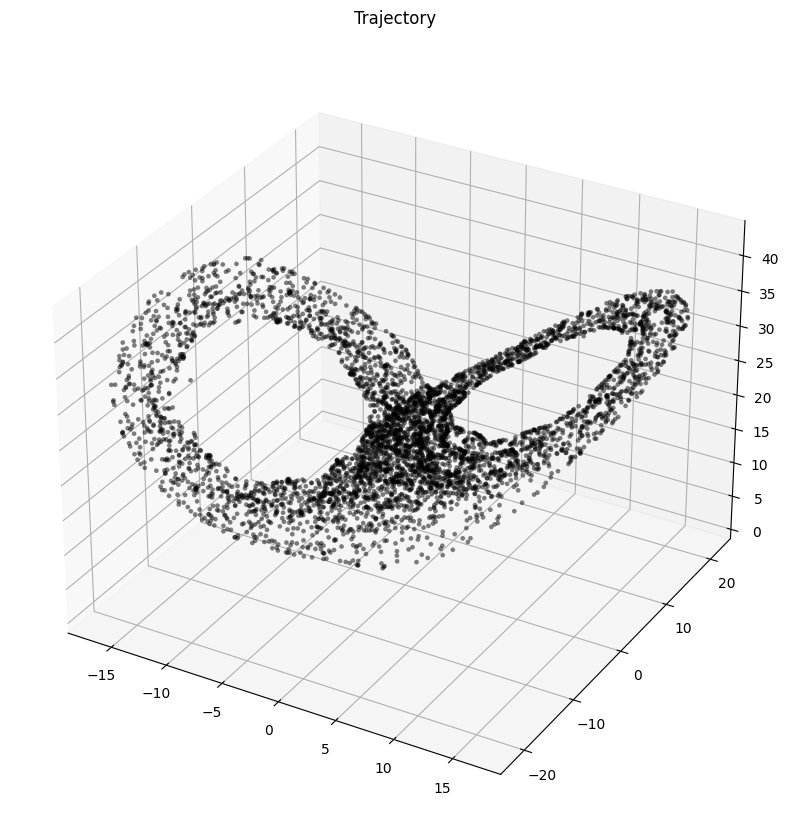

In [365]:
visualize_3d(obs = predictions)

In [367]:
predictions.shape

torch.Size([5000, 1, 3])

In [368]:
x_pred = predictions[:,:, 0]
y_pred = predictions[:, :,1]
z_pred = predictions[:, :,2]

In [369]:
x_train = true_lorenz[:, :, 0]
y_train = true_lorenz[:, :, 1]
z_train = true_lorenz[:, :, 2]

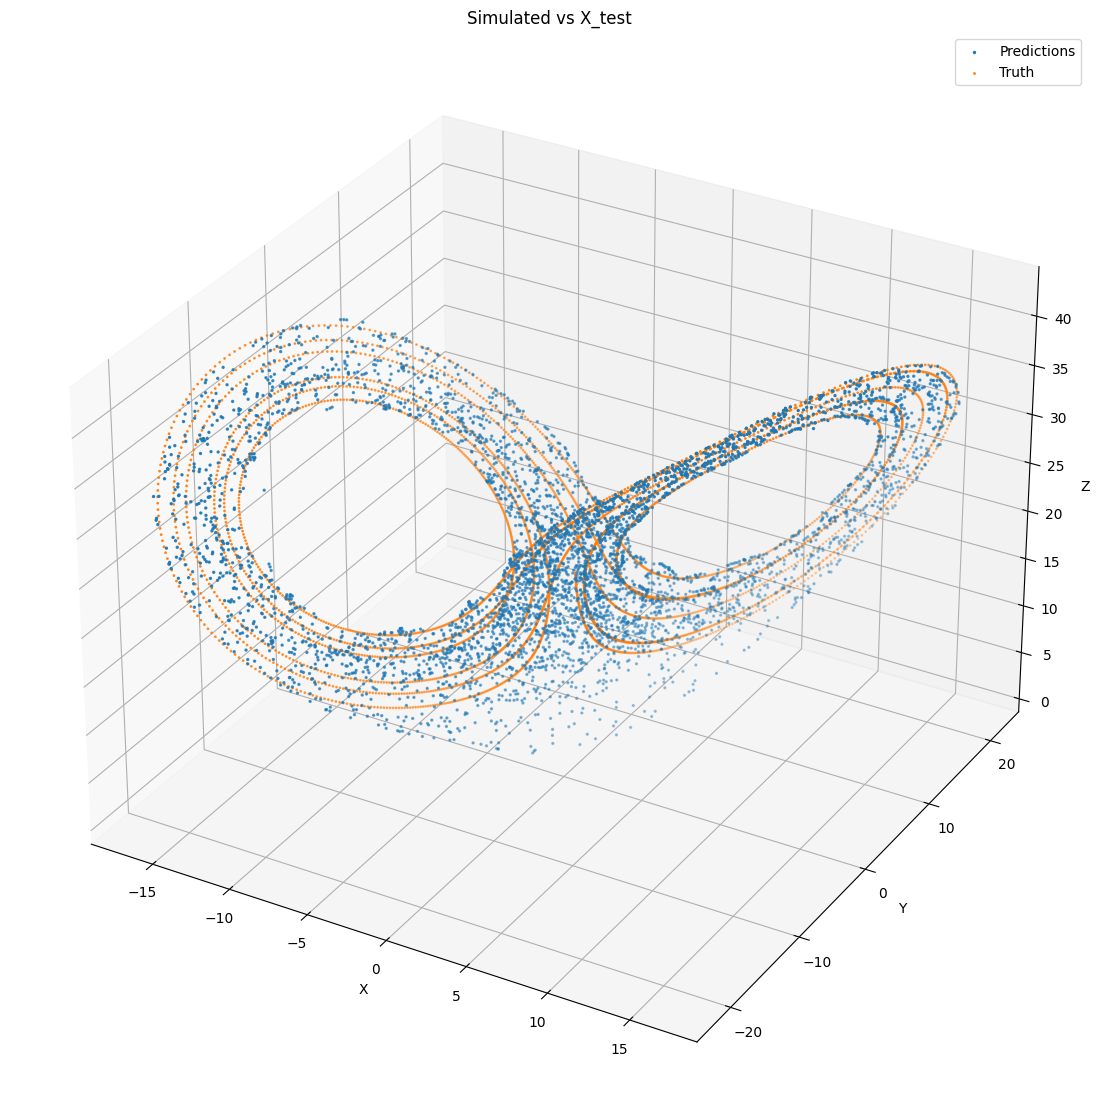

In [370]:
# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='Truth',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()

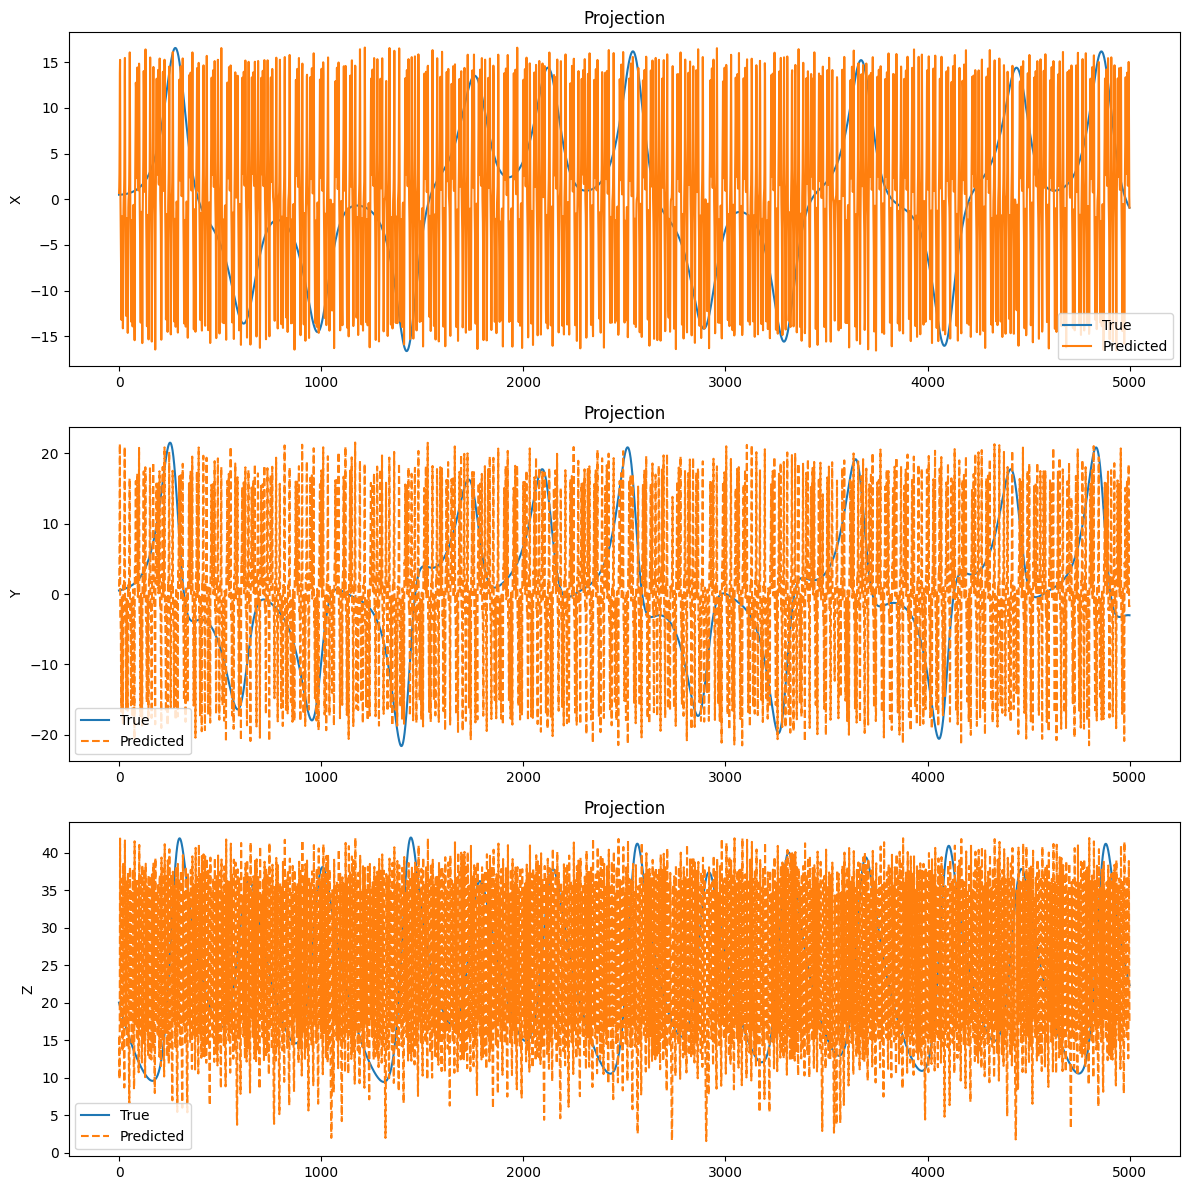

In [372]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted')

ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 30)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()